
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42)

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы построим дерево решений с нуля. Данное задание не является обязательным к выполнению, и больше направлена на ваш персональный интерес к тематике. За выполнение данного задания вы можете получить дополнительные баллы 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1Hyt4ZBH6T4o-qVHxuzdFQ9p-WaSiCr_ia2EcMxatKsg/edit?usp=sharing).**


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз , а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно пройдитесь по ноутбуку в разделе практики по деревьям решений. 

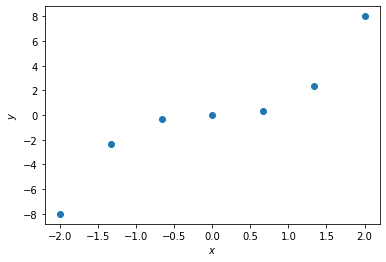

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

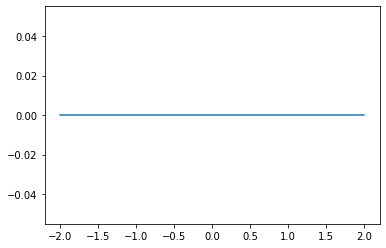

In [9]:
x = np.linspace(-2, 2, 100)
Y = round(y.mean(), 3)
plt.plot(x, [Y] * 100);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

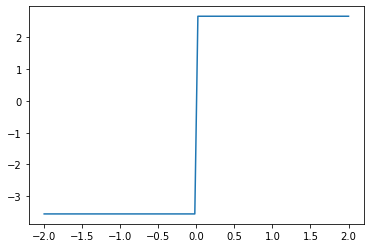

In [30]:
X1 = np.array(list((filter(lambda x: x < 0, X))))
X2 = np.array(list((filter(lambda x: x >= 0, X))))
Y1 = (X1 ** 3).mean()
Y2 = (X2 ** 3).mean()
plt.plot(x, list(map(lambda x: Y1 if x < 0 else Y2, x)));

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [50]:
def regression_var_criterion(X, y, t):
    l = y[X < t].var()*(X < t).mean()
    r = y[X >= t].var()*(X >= t).mean()
    return y.var() - l - r

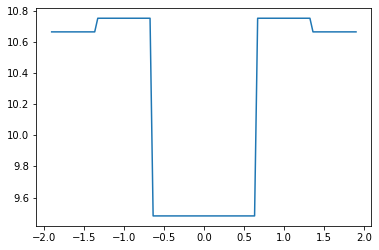

In [52]:
T = np.linspace(-1.9, 1.9, 100)
Q =  [regression_var_criterion(X, y, t) for t in T]
plt.plot(T, Q);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет <b><- This</b>

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

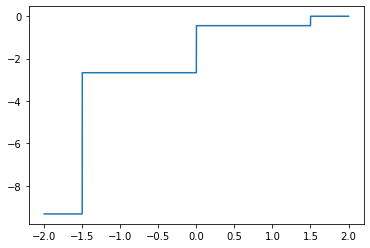

In [68]:
def prediction(train_x, train_y, x):
    y = train_y[train_x < -1.5].mean() * (x < -1.5)\
        +train_y[(-1.5 <= train_x) & (train_x < 0)].mean() * (-1.5 <= x < 0)\
        +train_y[(0 <= train_x) & (train_x < 1.5)].mean() * (0 <= x < 1.5)\
        +train_y[train_x <= 1.5].mean() * (x < 1.5)
    return y

x = np.linspace(-2, 2, 10000)
Y = [prediction(X, y, x) for x in x]
plt.plot(x, Y);


**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7 <b> <- This </b>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [70]:
df = pd.read_csv('../../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [71]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [78]:
df['years_age'] = round(df.age / 365.25)
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,years_age,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,52.0,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,48.0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [86]:
X = df.drop('cardio', axis = 1)
y = df['cardio']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

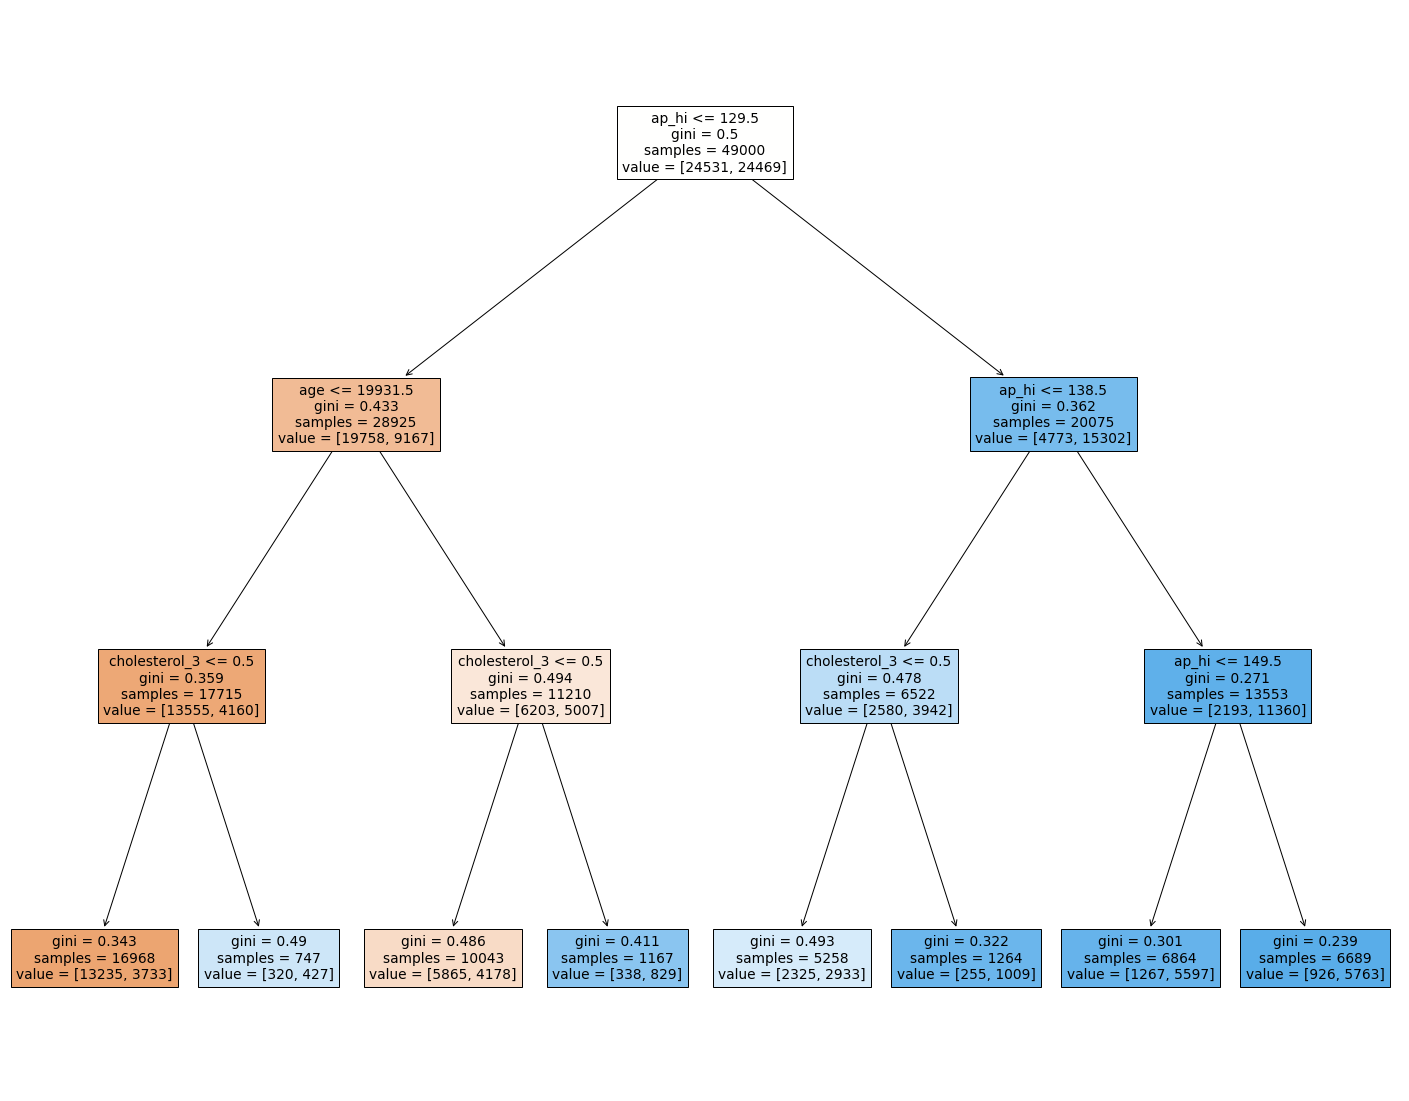

In [93]:
decision_tree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
decision_tree.fit(X_train, y_train)

from sklearn import tree as sktree

fig = plt.figure(figsize=(25,20))
sktree.plot_tree(
    decision_tree, 
    feature_names=X.columns,  
    filled=True);

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3 <b><- This </b>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [95]:
accuracy = decision_tree.score(X_valid, y_valid)
accuracy

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [113]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(decision_tree, {'max_depth': range(2, 11)}, cv=5)
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_score_)

{'max_depth': 6}
0.7319591836734693


Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

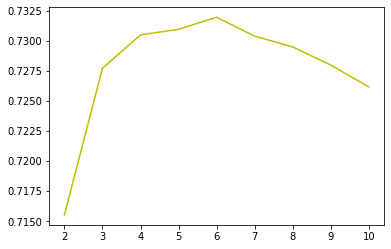

In [109]:
depths = np.array([params['max_depth'] for params in tree_grid.cv_results_['params']])
scores = np.array(tree_grid.cv_results_['mean_test_score'])
plt.plot(depths, scores, 'y');

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [118]:
print(tree_grid.best_params_)
print(tree_grid.score(X_valid, y_valid))
print((accuracy - tree_grid.score(X_valid, y_valid)) / accuracy * 100)

{'max_depth': 6}
0.7258095238095238
-0.6271869016967002


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет <b> <- This </b>
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.) <b> <- This </b>
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [145]:
def split_feature(
    df: pd.DataFrame, 
    new_df: pd.DataFrame,
    /,
    feature: str,
    left: int, 
    right: int, 
    step: int
):
    feature_bounds = [(x, x + step) for x in range(left, right, step)]
    for left, right in feature_bounds:
        new_df[f'{feature}_{left}_{right}'] = ((left <= df[feature]) & (df[feature] < right)).astype(int)



In [146]:
new_df = pd.DataFrame()   
split_feature(df, new_df, "years_age", 45, 65, 5)
split_feature(df, new_df, "ap_hi", 120, 180, 20)
new_df['male'] = df.gender - 1
for column in ['cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'smoke']:
    new_df[column] = df[column]

new_df

,years_age_45_50,years_age_50_55,years_age_55_60,years_age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,male,cholesterol_1,cholesterol_2,cholesterol_3,smoke
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,1,0,0,0
1,0,0,1,0,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,1,1,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,0,1,0,0,1,0,0,1,1,0,0,1
99995,0,0,0,1,0,1,0,0,0,1,0,0
99996,0,1,0,0,0,0,0,1,0,0,1,0


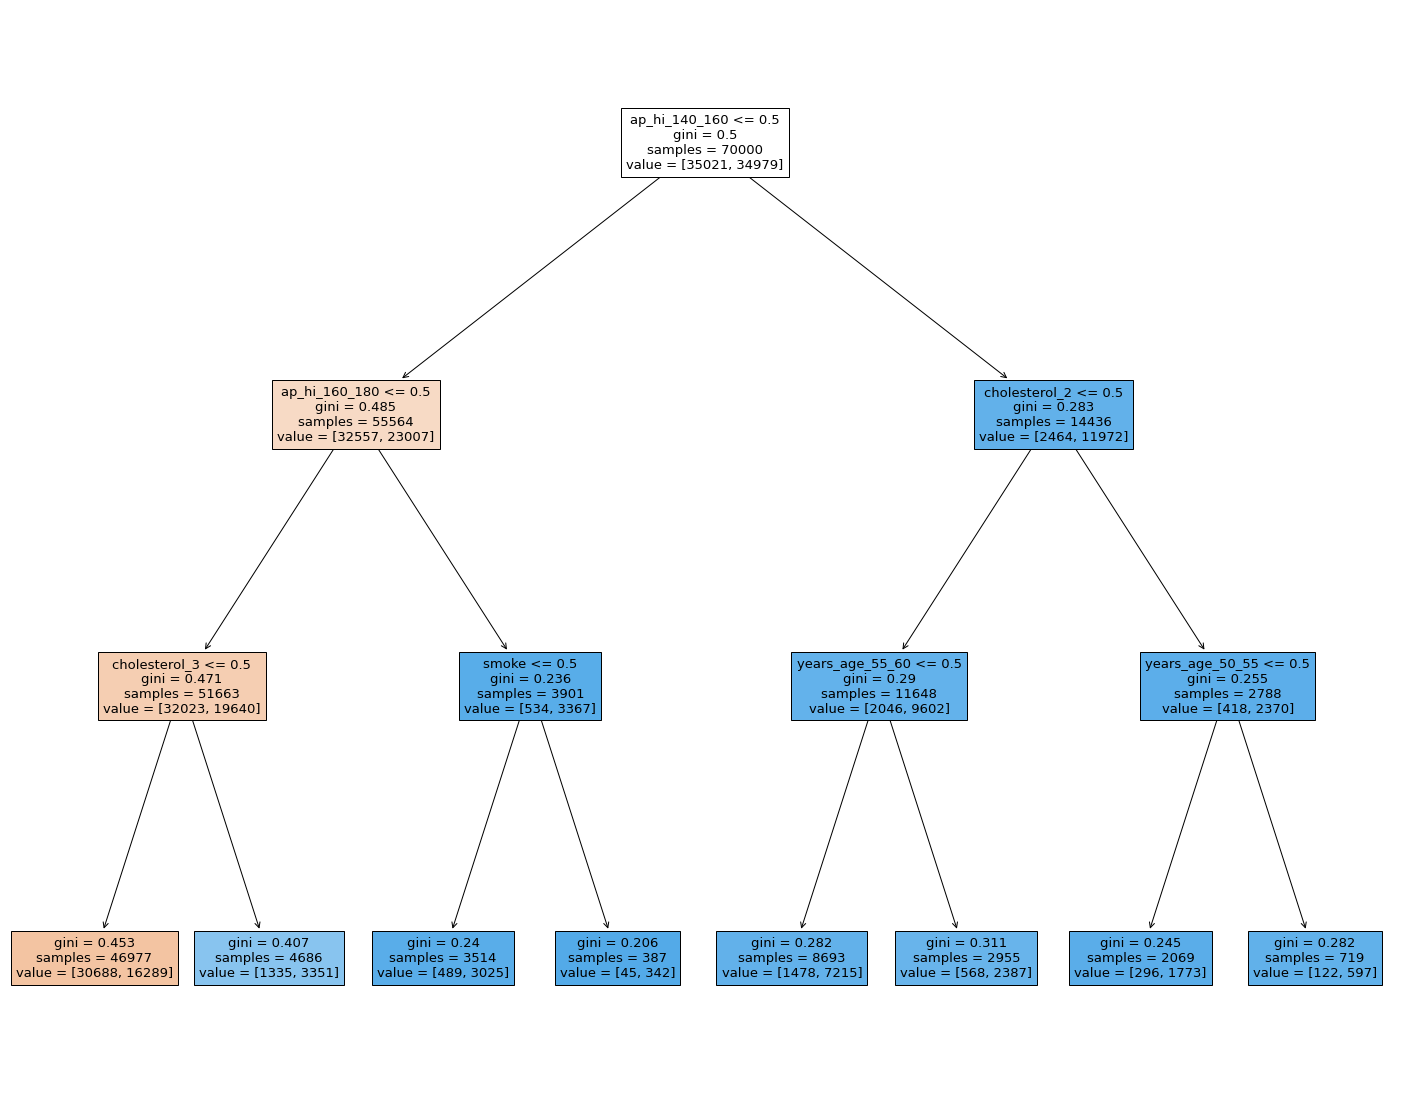

In [155]:
X = new_df
y = df.cardio

decision_tree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
decision_tree.fit(X, y)
fig = plt.figure(figsize=(25,20))
sktree.plot_tree(
    decision_tree, 
    feature_names=X.columns,  
    filled=True);